# Locust Swarming ODE Model

This notebook implements a simple ODE-based model of locust collective motion.  

Each locust is represented by three state variables:

- Position $(x, y)$: coordinates in a square domain of side length $L$ (meters), with periodic boundaries.  
- Heading angle $\theta$: direction of movement (radians).  
- Activity $a \in [0,1]$: a continuous measure of locomotion (0 = paused, 1 = fully moving).  

---

## Model Rules and Parameters

- ### Neighbor interactions  
  Locusts sense others within a vision radius $R$ (meters). Their heading aligns to neighbors at rate $\kappa$ (per second), which sets the strength of directional coupling.

- ### Activity dynamics  
  Each locust’s activity relaxes toward a sigmoid function of its neighbor count $n_i$:  

  $$
  \frac{da_i}{dt} = -\frac{1}{\tau_a}\Big(a_i - \sigma(\beta_0 + \beta_1 n_i)\Big)
  $$

  where:  
  - $\tau_a$ (seconds): relaxation timescale  
  - $\beta_0$ (dimensionless): baseline activity bias (negative = inactive when alone)  
  - $\beta_1$ (dimensionless): social activation gain, controlling how strongly activity increases with neighbors  

- ### Velocity  
  Speed interpolates between a minimum speed $v_{\min}$ (m/s) when inactive and a maximum speed $v_{\max}$ (m/s) when active:  

  $$
  v_i = v_{\min} + (v_{\max} - v_{\min})a_i
  $$

- ### Heading update with noise  
  The heading angle changes according to neighbor alignment plus angular noise:  

  $$
  \frac{d\theta_i}{dt} = \kappa \cdot \langle \sin(\theta_j - \theta_i)\rangle + \sqrt{2\eta}\,\xi
  $$

  where:  
  - $\eta$ ($\text{rad}^2/\text{s}$): angular noise intensity, acts like a diffusion coefficient in angle space
  - $\xi$: Gaussian white noise with mean 0 and variance 1  

- ### Domain  
  Motion occurs in a periodic box of size $L \times L$, so locusts exiting one side re-enter on the opposite side.


In [18]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import pi

## Parameters

We separate mathematical parameters (biological meaning) from computational parameters (simulation control).


In [19]:
@dataclass
class MathParams:
    N: int = 120        # Number of locusts [count]
    L: float = 10.0     # Domain size [m]
    v_min: float = 0.01 # Minimum speed [m/s]
    v_max: float = 0.15 # Maximum speed [m/s]
    kappa: float = 2.0  # Alignment strength [1/s]
    R: float = 1.0      # Vision radius [m]
    eta: float = 0.4    # Noise intensity [rad/s^0.5]
    beta0: float = -1.0 # Baseline activity bias [—]
    beta1: float = 0.25 # Social activation gain [—]
    tau_a: float = 0.5  # Relaxation time [s]

@dataclass
class CompParams:
    dt: float = 0.05    # Time step [s]
    T: float = 100.0    # Total simulation time [s]
    seed: int = 42      # Random seed


## Helper functions


In [20]:
def wrap_positions(pos, L):
    pos[:, 0] %= L
    pos[:, 1] %= L

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def polarization(theta):
    vx, vy = np.cos(theta).mean(), np.sin(theta).mean()
    return np.sqrt(vx**2 + vy**2)


## Simulation Function


In [21]:
def simulate(math: MathParams, comp: CompParams):
    rng = np.random.default_rng(comp.seed)
    N, L = math.N, math.L
    dt, steps = comp.dt, int(comp.T / comp.dt)

    # Initial state
    pos = rng.uniform(0, L, size=(N, 2))
    theta = rng.uniform(-pi, pi, size=N)
    a = rng.uniform(0, 1, size=N)

    time, pols, acts = [], [], []

    for t in range(steps):
        # Distances with periodic wrap
        dx = pos[:, None, 0] - pos[None, :, 0]
        dy = pos[:, None, 1] - pos[None, :, 1]
        dx -= np.round(dx / L) * L
        dy -= np.round(dy / L) * L
        dist2 = dx**2 + dy**2

        mask = (dist2 < math.R**2) & (dist2 > 0)
        nbh_counts = mask.sum(axis=1)

        # Heading update
        align_term = np.zeros(N)
        for i in range(N):
            if nbh_counts[i] > 0:
                align_term[i] = (
                    math.kappa / nbh_counts[i] *
                    np.sum(np.sin(theta[mask[i]] - theta[i]))
                )
        theta += dt * align_term + np.sqrt(2 * math.eta * dt) * rng.normal(size=N)

        # Activity update
        a_inf = sigmoid(math.beta0 + math.beta1 * nbh_counts)
        a += dt * (-(a - a_inf) / math.tau_a)
        a = np.clip(a, 0, 1)

        # Position update
        speed = math.v_min + (math.v_max - math.v_min) * a
        pos[:, 0] += dt * speed * np.cos(theta)
        pos[:, 1] += dt * speed * np.sin(theta)
        wrap_positions(pos, L)

        # Record
        if t % 5 == 0:
            time.append(t * dt)
            pols.append(polarization(theta))
            acts.append(a.mean())

    return {
        "time": np.array(time),
        "polarization": np.array(pols),
        "activity": np.array(acts),
    }


## Run a baseline simulation


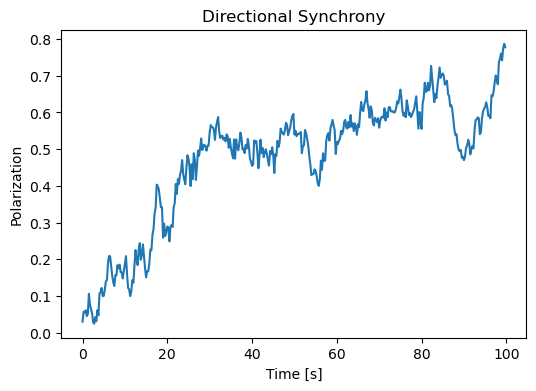

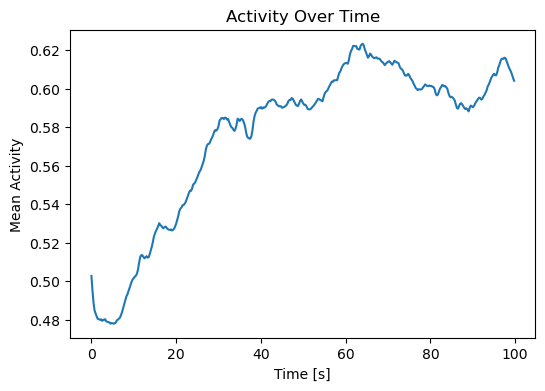

In [22]:
mp = MathParams()
cp = CompParams()

ts = simulate(mp, cp)

# Plot polarization
plt.figure(figsize=(6,4))
plt.plot(ts["time"], ts["polarization"])
plt.xlabel("Time [s]")
plt.ylabel("Polarization")
plt.title("Directional Synchrony")
plt.show()

# Plot mean activity
plt.figure(figsize=(6,4))
plt.plot(ts["time"], ts["activity"])
plt.xlabel("Time [s]")
plt.ylabel("Mean Activity")
plt.title("Activity Over Time")
plt.show()


## Robustness Analysis

We quantify robustness by scanning model parameters and plotting 2D heatmaps of an
aggregate outcome. Here we use the average polarization over the last half of the
simulation as the outcome (higher = stronger directional synchrony).


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict
from pathlib import Path

def summarize_synchrony(ts: dict, last_fraction: float = 0.5) -> float:
    """Average polarization over the last fraction of the simulation."""
    t = ts["time"]
    cutoff = t[-1] * (1.0 - last_fraction)
    mask = t >= cutoff
    return float(np.mean(ts["polarization"][mask]))

def scan_params_2d(
    x_values: np.ndarray,
    y_values: np.ndarray,
    x_name: str,
    y_name: str,
    base_math: MathParams,
    base_comp: CompParams,
    T_scan: float = 60.0,
    seed: int | None = None,
) -> pd.DataFrame:
    """
    Run a 2D grid scan over (x_name, y_name); return a tidy DataFrame with
    columns [x_name, y_name, polarization_last_half].
    """
    rows = []
    # shorter total time for faster scans
    comp = CompParams(dt=base_comp.dt, T=T_scan, seed=(seed if seed is not None else base_comp.seed))
    for xv in x_values:
        for yv in y_values:
            mp_dict = asdict(base_math)
            mp_dict[x_name] = float(xv)
            mp_dict[y_name] = float(yv)
            mp = MathParams(**mp_dict)
            ts = simulate(mp, comp)
            pol = summarize_synchrony(ts, last_fraction=0.5)
            rows.append({x_name: float(xv), y_name: float(yv), "polarization_last_half": pol})
    return pd.DataFrame(rows)

def plot_heatmap(df: pd.DataFrame, x_name: str, y_name: str, value_col: str, title: str):
    """Plot a simple imshow heatmap from a tidy scan DataFrame."""
    # Pivot to 2D array
    grid = df.pivot(index=y_name, columns=x_name, values=value_col)
    grid = grid.sort_index(ascending=True)  # y ascending
    plt.figure(figsize=(6, 5))
    plt.imshow(
        grid.values,
        origin="lower",
        aspect="auto",
        extent=[grid.columns.min(), grid.columns.max(), grid.index.min(), grid.index.max()],
    )
    cbar = plt.colorbar()
    cbar.set_label("Polarization (avg over last 50% of run)")
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    plt.title(title)
    plt.tight_layout()
    plt.show()


### Scan 1: Alignment strength (κ) × Vision radius (R)

Hypothesis: there are thresholds in κ and R beyond which collective motion (polarization)
emerges. We expect a low-polarization region for small κ/R and a higher-polarization region
once coupling/neighborhood size is sufficient.


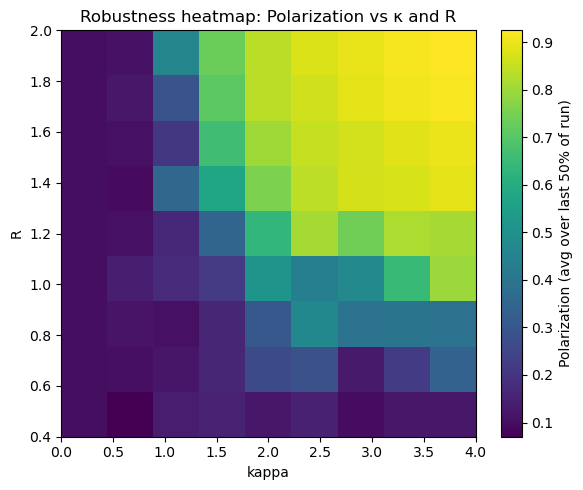

In [24]:
# Define grids (adjust resolution for speed/quality)
kappa_vals = np.linspace(0.0, 4.0,  nine:=9)  # 0, 0.5, ..., 4.0
R_vals     = np.linspace(0.4, 2.0,  nine)

df_kappa_R = scan_params_2d(
    x_values=kappa_vals,
    y_values=R_vals,
    x_name="kappa",
    y_name="R",
    base_math=mp,
    base_comp=cp,
    T_scan=60.0,   # shorter than baseline to keep scans quick
)

plot_heatmap(
    df_kappa_R, x_name="kappa", y_name="R",
    value_col="polarization_last_half",
    title="Robustness heatmap: Polarization vs κ and R",
)

# Save for the report
Path("results").mkdir(exist_ok=True, parents=True)
df_kappa_R.to_csv("results/heatmap_kappa_R.csv", index=False)


### Scan 2: Social activation (β₁) × Alignment strength (κ)

Hypothesis: social activation (how strongly neighbor count boosts activity) interacts with
alignment. Higher β₁ should make bursts of activity more coherent, lowering the κ needed for order.


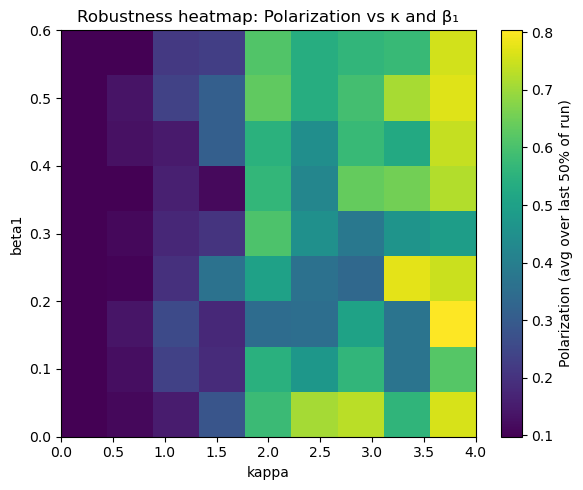

In [25]:
beta_vals  = np.linspace(0.0, 0.6, nine)
kappa_vals = np.linspace(0.0, 4.0,  nine)

df_beta_kappa = scan_params_2d(
    x_values=kappa_vals,
    y_values=beta_vals,
    x_name="kappa",
    y_name="beta1",
    base_math=mp,
    base_comp=cp,
    T_scan=60.0,
)

plot_heatmap(
    df_beta_kappa, x_name="kappa", y_name="beta1",
    value_col="polarization_last_half",
    title="Robustness heatmap: Polarization vs κ and β₁",
)

df_beta_kappa.to_csv("results/heatmap_kappa_beta1.csv", index=False)
